In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, confusion_matrix, 
                           roc_curve, auc, classification_report)
from sklearn.preprocessing import label_binarize
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten, Dense, 
                                   Dropout, BatchNormalization, GlobalAveragePooling2D)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import AdamW
from PIL import Image
import warnings
import math

warnings.filterwarnings('ignore')

In [ ]:
DATASET_PATH = 'C:\Archive of interest\MODEL_CNN'  
TRAIN_PATH = os.path.join(DATASET_PATH, 'train')
VALIDATION_PATH = os.path.join(DATASET_PATH, 'validation')

In [ ]:
IMG_SIZE = 224 
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.0001

CLASS_NAMES = ['cheetah', 'hyena']
NUM_CLASSES = len(CLASS_NAMES)

print(f"Ukuran gambar: {IMG_SIZE}x{IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Jumlah epoch: {EPOCHS}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Kelas: {CLASS_NAMES}")

Ukuran gambar: 224x224
Batch size: 32
Jumlah epoch: 50
Learning rate: 0.0001
Kelas: ['cheetah', 'hyena']


In [9]:
def preview_dataset():
    for split in ['train', 'validation']:
        split_path = os.path.join(DATASET_PATH, split)
        print(f"\n{split.upper()} SET:")
        
        total_files = 0
        for class_name in CLASS_NAMES:
            class_path = os.path.join(split_path, class_name)
            if os.path.exists(class_path):
                num_files = len([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
                print(f"  {class_name}: {num_files} gambar")
                total_files += num_files
        print(f"  Total: {total_files} gambar")
        
preview_dataset()


TRAIN SET:
  cheetah: 900 gambar
  hyena: 900 gambar
  Total: 1800 gambar

VALIDATION SET:
  cheetah: 100 gambar
  hyena: 100 gambar
  Total: 200 gambar


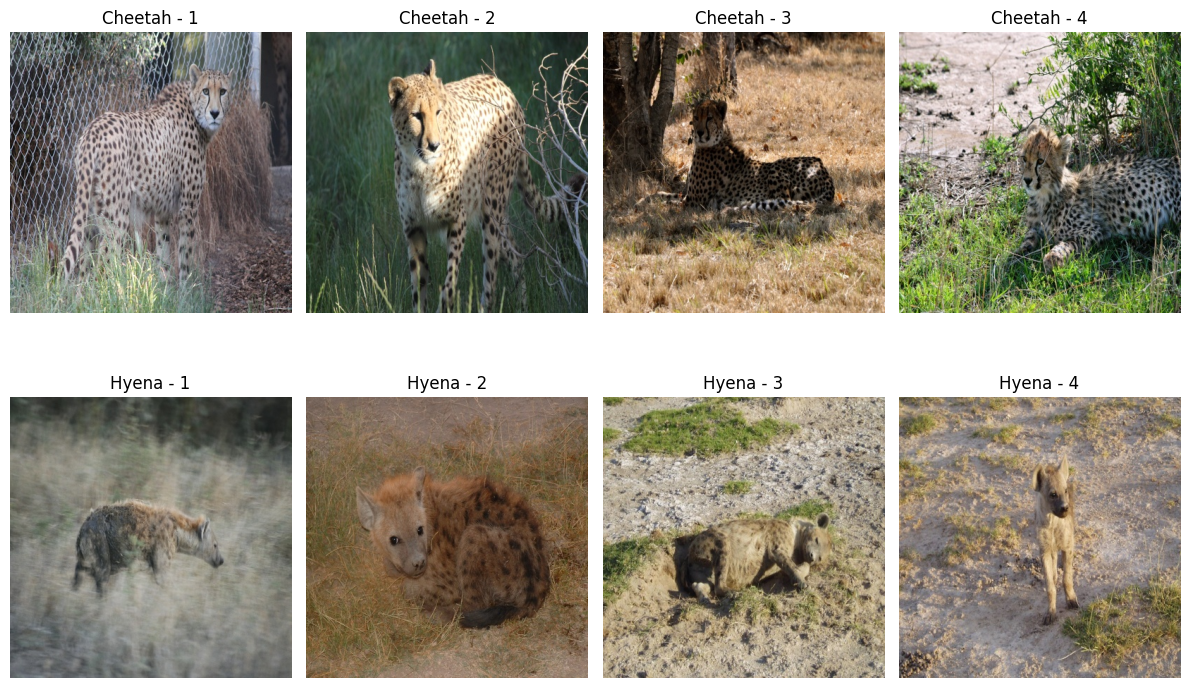

In [ ]:
def sample_images():
    plt.figure(figsize=(12, 8))
    for i, class_name in enumerate(CLASS_NAMES):
        class_path = os.path.join(TRAIN_PATH, class_name)
        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        
        for j in range(4):
            plt.subplot(2, 4, i*4 + j + 1)
            img_path = os.path.join(class_path, images[j])
            img = Image.open(img_path)
            plt.imshow(img)
            plt.title(f'{class_name.capitalize()} - {j+1}')
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
sample_images()

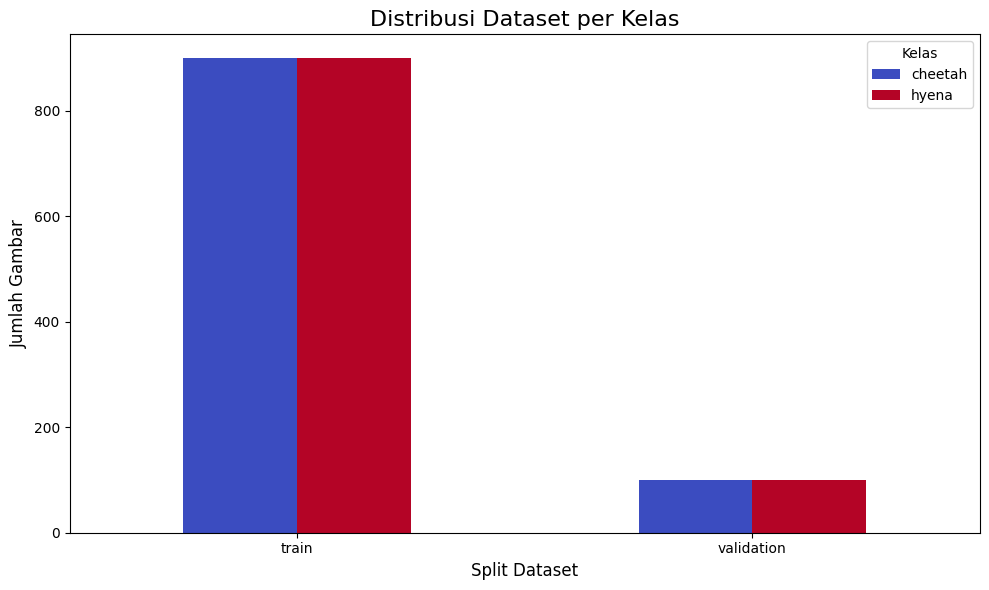

In [11]:
distribution_data = {
    'train': {'cheetah': 900, 'hyena': 900},
    'validation': {'cheetah': 100, 'hyena': 100}
}

df_distribution = pd.DataFrame(distribution_data)

plt.figure(figsize=(10, 6))
df_distribution.T.plot(kind='bar', colormap='coolwarm', ax=plt.gca())
plt.title('Distribusi Dataset per Kelas', fontsize=16)
plt.xlabel('Split Dataset', fontsize=12)
plt.ylabel('Jumlah Gambar', fontsize=12)
plt.legend(title='Kelas')
plt.xticks(rotation=0, ha='center')
plt.tight_layout()
plt.show()

In [12]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [13]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=True, seed=42
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_PATH, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False
)

Found 1800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [14]:
print(f"Data training: {train_generator.samples} gambar")
print(f"Data validation: {validation_generator.samples} gambar")
print(f"Class indices: {train_generator.class_indices}")

Data training: 1800 gambar
Data validation: 200 gambar
Class indices: {'cheetah': 0, 'hyena': 1}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


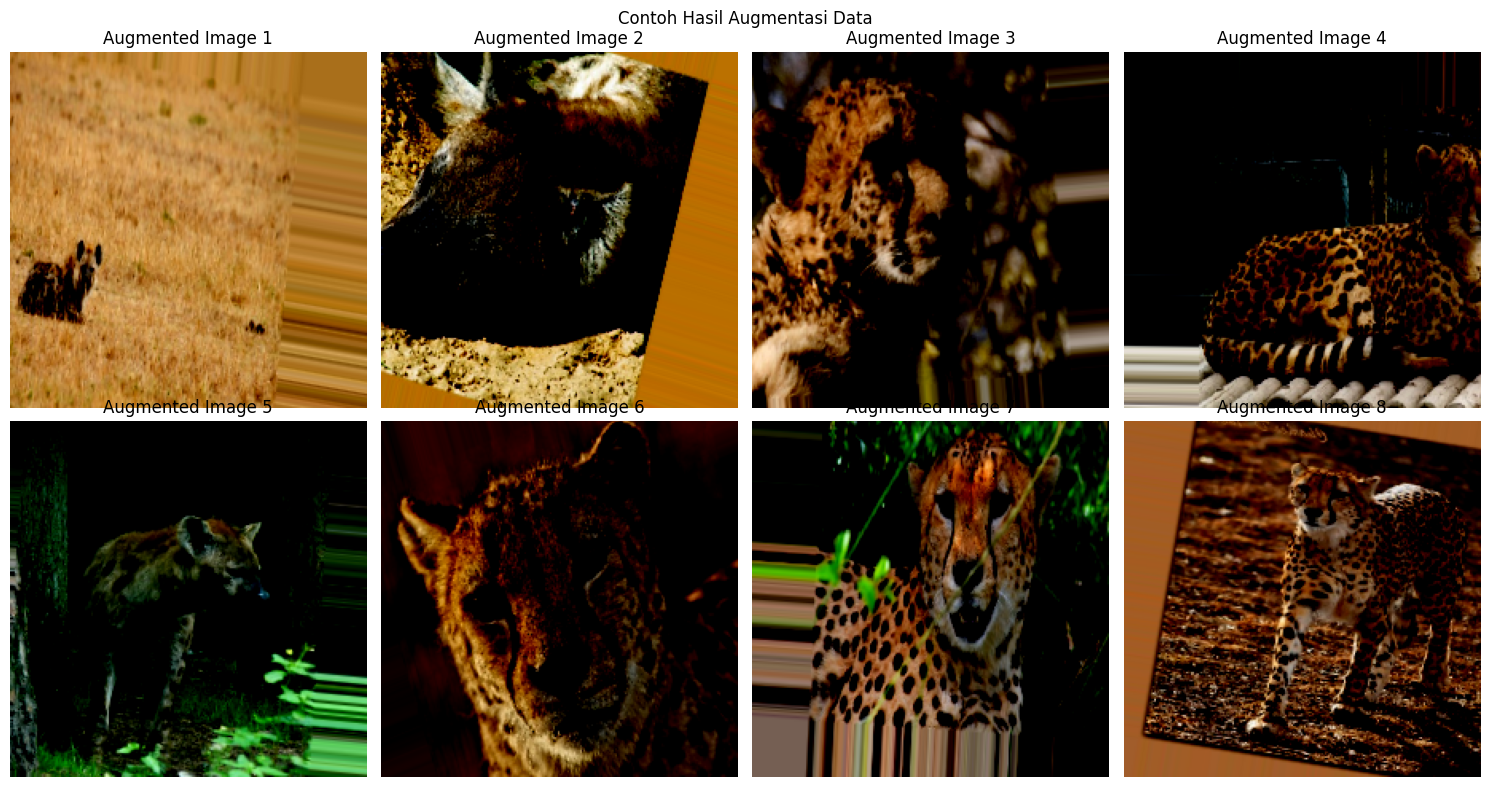

In [ ]:
def augmented_images():
    sample_batch = next(train_generator)  
    sample_images = sample_batch[0][:8]  
    
    plt.figure(figsize=(15, 8))
    for i in range(8):
        plt.subplot(2, 4, i + 1)
        plt.imshow(sample_images[i])
        plt.title(f'Augmented Image {i+1}')
        plt.axis('off')
    
    plt.suptitle('Contoh Hasil Augmentasi Data')
    plt.tight_layout()
    plt.show()

augmented_images()

In [ ]:
def model_cnn():
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    base_model.trainable = False 

    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x) 
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
    
    model = models.Model(inputs, outputs)
    return model

In [17]:
model = model_cnn()
model.compile(
    optimizer=AdamW(learning_rate=LEARNING_RATE, weight_decay=0.004),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [18]:
model_cnn = model_cnn()
model_cnn.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         2,562 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [1]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_transfer_model.keras', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)
callbacks_list = [early_stopping, model_checkpoint, reduce_lr

SyntaxError: incomplete input (3967038080.py, line 4)

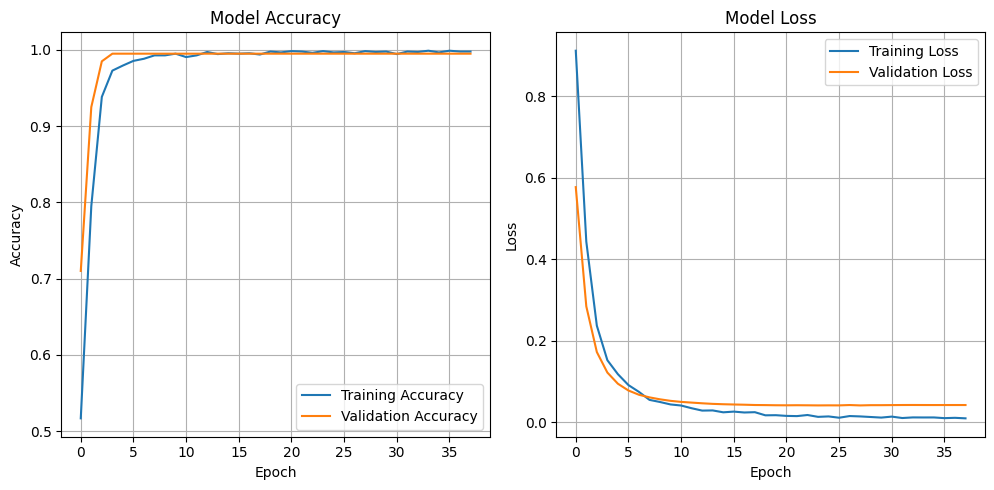

In [ ]:
def plot_training_history():

    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 3, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

plot_training_history()

In [ ]:
best_model = load_model('best_transfer_model.keras')

true_classes = validation_generator.classes
steps_for_prediction = int(np.ceil(validation_generator.samples 

predictions = best_model.predict(
    validation_generator, 
    steps=steps_for_prediction
)

predicted_classes = np.argmax(predictions, axis=1)
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 699ms/step
              precision    recall  f1-score   support

     cheetah       1.00      0.99      0.99       100
       hyena       0.99      1.00      1.00       100

    accuracy                           0.99       200
   macro avg       1.00      0.99      0.99       200
weighted avg       1.00      0.99      0.99       200



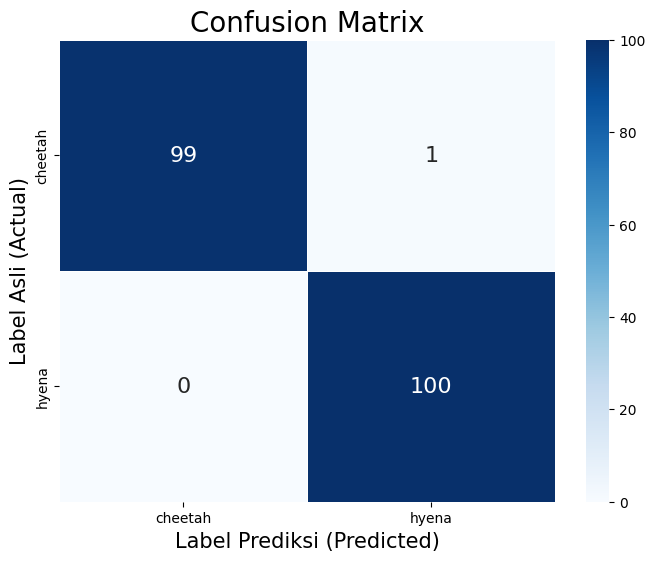

In [ ]:
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels,
            linewidths=0.5, annot_kws={"size": 16})

plt.title('Confusion Matrix', fontsize=20)
plt.ylabel('Label Asli (Actual)', fontsize=15)
plt.xlabel('Label Prediksi (Predicted)', fontsize=15)
plt.show()

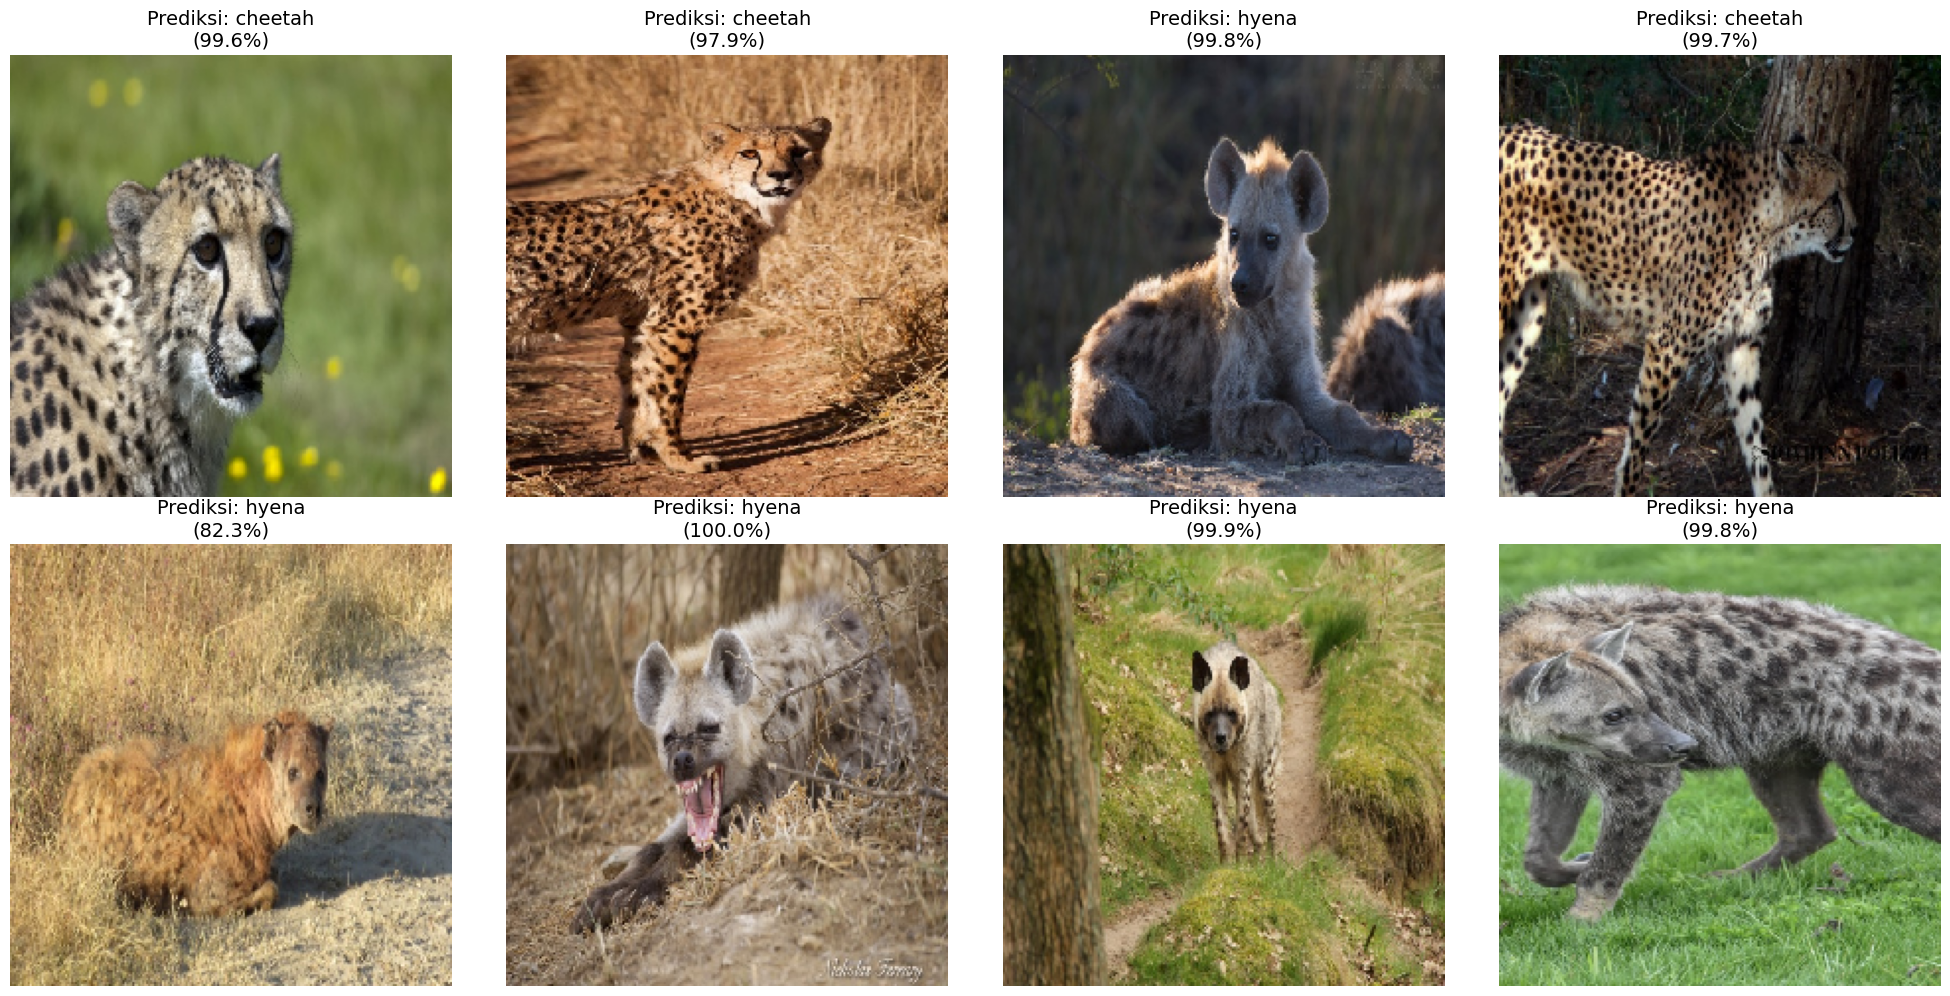

In [ ]:
import random

MODEL_PATH = 'best_transfer_model.keras'
NUM_SAMPLES = 8

all_images = []
for class_name in CLASS_NAMES:
    class_path = os.path.join(VALIDATION_PATH, class_name)
    if os.path.exists(class_path):
        all_images.extend([os.path.join(class_path, f) for f in os.listdir(class_path)])

sample_paths = random.sample(all_images, min(NUM_SAMPLES, len(all_images)))
model = load_model(MODEL_PATH)

plt.figure(figsize=(20, 10))

for i, img_path in enumerate(sample_paths):
    plt.subplot(2, 4, i + 1)
    
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img)
    img_preprocessed = preprocess_input(np.expand_dims(img_array, axis=0))
    
    prediction = model.predict(img_preprocessed, verbose=0)
    plt.imshow(img)
    confidence = np.max(prediction)
    predicted_class = CLASS_NAMES[np.argmax(prediction)]
    plt.title(f"Prediksi: {predicted_class}\n({confidence:.1%})", fontsize=14)
    plt.axis('off')

plt.tight_layout()
plt.show()

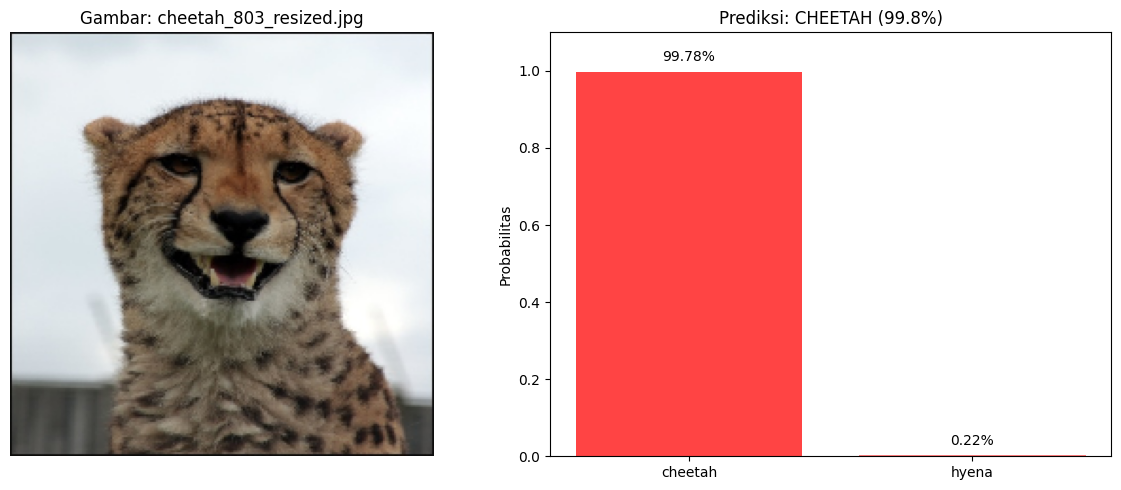

In [46]:
import tkinter as tk
from tkinter import filedialog

MODEL_PATH = 'best_transfer_model.keras'

def predict_and_visualize(image_path, model):
    img = image.load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img)
    img_preprocessed = preprocess_input(np.expand_dims(img_array, axis=0))
    
    prediction = model.predict(img_preprocessed, verbose=0)
    
    confidence = np.max(prediction)
    predicted_class_index = np.argmax(prediction)
    predicted_class_name = CLASS_NAMES[predicted_class_index]

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f"Gambar: {os.path.basename(image_path)}")
    plt.axis('off')
    

    plt.subplot(1, 2, 2)
    colors = ['#ff7f7f' if i != predicted_class_index else '#ff4444' for i in range(len(CLASS_NAMES))]
    bars = plt.bar(CLASS_NAMES, prediction[0], color=colors)
    plt.title(f'Prediksi: {predicted_class_name.upper()} ({confidence:.1%})')
    plt.ylabel('Probabilitas')
    plt.ylim(0, 1.1)
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                 f'{height:.2%}', ha='center', va='bottom')
        
    plt.tight_layout()
    plt.show()

model = load_model(MODEL_PATH)

root = tk.Tk()
root.withdraw()
file_path = filedialog.askopenfilename(title="Pilih gambar untuk diprediksi", 
                                     filetypes=[("Image files", "*.jpg *.jpeg *.png")])

if file_path:
    predict_and_visualize(file_path, model)